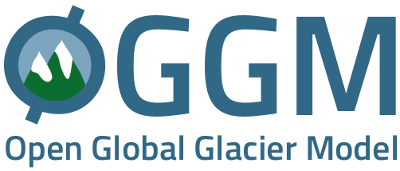

In [ ]:
# more maritime conditions lead to steeper mass balance gradients. 
# Vary the mass balance gradient and examine the response time and 
# equilibrium glacier profiles for various values of the mass balance gradient.

# Getting started with flowline models: Mass balance gradients (MBG)
If the concept of mass balance is completely new to you, have a short read about it [here](http://www.antarcticglaciers.org/glacier-processes/introduction-glacier-mass-balance/) up to the paragraph "*So what is Glacier Mass Balance?*". In this notebook we will set-up a few simple runs to compare the impact of different MBG on our glacier model.

First, we have to import all needed modules:

In [1]:
# The commands below are just importing the necessary modules and functions
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size
# Scientific packages
import numpy as np
import pandas as pd

# Constants
from oggm import cfg
cfg.initialize()
# OGGM models
from oggm.core.massbalance import LinearMassBalance
from oggm.core.flowline import FluxBasedModel, RectangularBedFlowline, TrapezoidalBedFlowline, ParabolicBedFlowline
# There are several solvers in OGGM core. We use the default one for this experiment
FlowlineModel = FluxBasedModel

import hide_functions as hf

2019-01-14 11:15:25: oggm.cfg: Using configuration file: /home/zora/Dokumente/git/oggm/oggm/params.cfg


We set-up a simple run with a linear bed. (We do similiar steps like in [flowline_model](http://edu.oggm.org/en/latest/notebooks_flowline_intro.html#glacier-flowline-modelling) to generate a set-up for our experiment.)

In [2]:
# This is the bed rock, linearily decreasing from 3400m altitude to 1400m, in 200 steps
nx = 200
bed_h = np.linspace(3400, 1400, nx)
# At the begining, there is no glacier so our glacier surface is at the bed altitude
surface_h = bed_h
# Let's set the model grid spacing to 100m 
map_dx = 100
# calculate the corresponding distance along the glacier (from the top)
distance_along_glacier = np.linspace(0,nx, nx) *0.1 # in km 
# The units of widths is in "grid points", i.e. 3 grid points = 300 m in our case
widths = np.zeros(nx) + 3.
# Define our bed
init_flowline = RectangularBedFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

## Changing the mass balance gradient (MBG)
The MBG depends strongly on the climate. Changing the MBG influences for example the glacier's response time. (If you want to know a little bit more about it, have a look at this short [paragraph](http://www.antarcticglaciers.org/modern-glaciers/introduction-glacier-mass-balance/#SECTION_3).)
Let's have a look at some examples:

In [3]:
# Define the MBGs we want to compare: (we worked with grad=4 in the 
# glacier flowline modelling notebook)
# We will calculate models with the MBGs: 1, 4 and 10 
grad = [0.3, 4, 15]
# Define the time period for which the glacier should be calculated:
years = 300

In [4]:
# In the following lists the intermediate steps of the models will be saved
mb_models = []
annual_mb = []
# here the "final" models will be saved
models = []
# Colors for the graphs
colors = ['C1', 'C3', 'C5'] 

for k, gradient in enumerate(grad):
    # Calculation of the mass balance models for each gradient 
    a = LinearMassBalance(3000, grad=gradient)
    mb_models.append(a)
    # Calculation of the annual mass balance along the glacier profile
    annual_mb.append(a.get_annual_mb(surface_h) * cfg.SEC_IN_YEAR)
    # The models require the initial glacier bed, a mass-balance model, and an initial time (the year y0)
    models.append(FlowlineModel(init_flowline, mb_model=a, y0=0.))
    # First, look at the state of the glacier models after the chosen amount of years
    models[k].run_until(years)

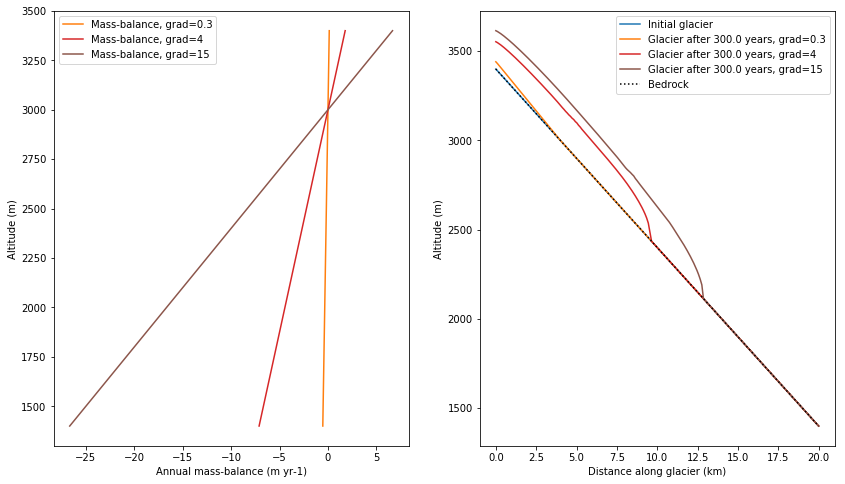

In [5]:
# Plot the results
plt.figure(figsize=[14,8])

plt.subplot(121)
# Annual mass balance
for k, ann_mb in enumerate(annual_mb):
    plt.plot(ann_mb, bed_h, color=colors[k], label='Mass-balance, grad='+ str(grad[k]))
plt.xlabel('Annual mass-balance (m yr-1)')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

plt.subplot(122)
# Plot the initial conditions first:
plt.plot(distance_along_glacier, init_flowline.surface_h, label='Initial glacier')
# Get the modelled flowline (model.fls[-1]) and plot its new surface
for k, model in enumerate(models):
    plt.plot(distance_along_glacier, model.fls[-1].surface_h, label='Glacier after {} years, '.format(model.yr) + 'grad=' + str(grad[k]), color=colors[k])
# Add the bedrock:
hf.plot_xz_bed(distance_along_glacier, bed_h)

Different mass balance gradients lead to different annual mass balances with the result that higher gradients show shallower slopes. The model with the highest gradient (purple line) shows the longest und thickest glacier. What do you think: where do find glaciers with high MBGs? 

## Equilibrium state 

Glaciers change their form to adapt to the climate. When the climate stays constant they will reach an equilibrium state. Now we will look how fast glaciers with different gradients reach this state and compare their shapes:

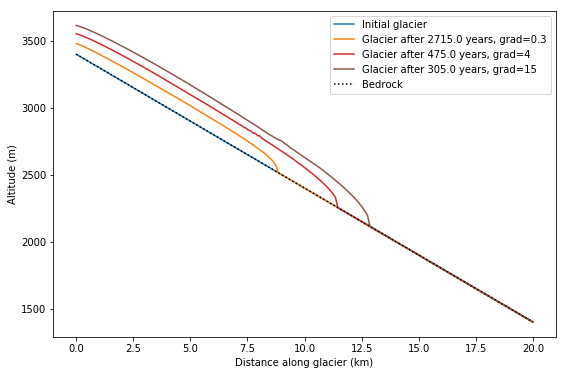

In [6]:
# Plot it
plt.figure(figsize=[9,6])
# Plot the initial conditions first:
plt.plot(distance_along_glacier, init_flowline.surface_h, label='Initial glacier')
# model with gradient smaller 1 will have problems to find the equilibrium because the function searches only 
# 1000 years ahead and the glacier needs more time to reacht the eq-state:
models[0].run_until(2000)

for k, model in enumerate(models):
    # Run the different glacier models until they reach an equilibrium state
    model.run_until_equilibrium()
    # Get the modelled flowline (model.fls[-1]) and plot its new surface
    plt.plot(distance_along_glacier, model.fls[-1].surface_h, label='Glacier after {} years, '.format(model.yr) + 'grad=' + str(grad[k]), color=colors[k])
# Add the bedrock:
hf.plot_xz_bed(distance_along_glacier, bed_h)

The different models reach their equilibrium state after different amounts of years. What does the figure show us? Which glacier is the thickest and longest? Let's look at specific numbers: 

In [7]:
# Create lists with different properties of the glacier models
volume = []
area = []
length = []
year = []

for model in models:
    year.append(model.yr)
    volume.append(model.volume_km3)
    length.append(model.length_m)
    area.append(model.area_km2)

# Create a table with the properties of the glacier models
dic = {'grad': [1, 4, 10], 'year': year, 'volume': volume, 'area': area, 'length': length}
table = pd.DataFrame.from_dict(dic)
table

,grad,year,volume,area,length
0,1,2715.0,0.276183,2.67,8900.0
1,4,475.0,0.614229,3.42,11400.0
2,10,305.0,0.921246,3.84,12800.0


### Volume

Let's have a close look at the volume of the glacier models:

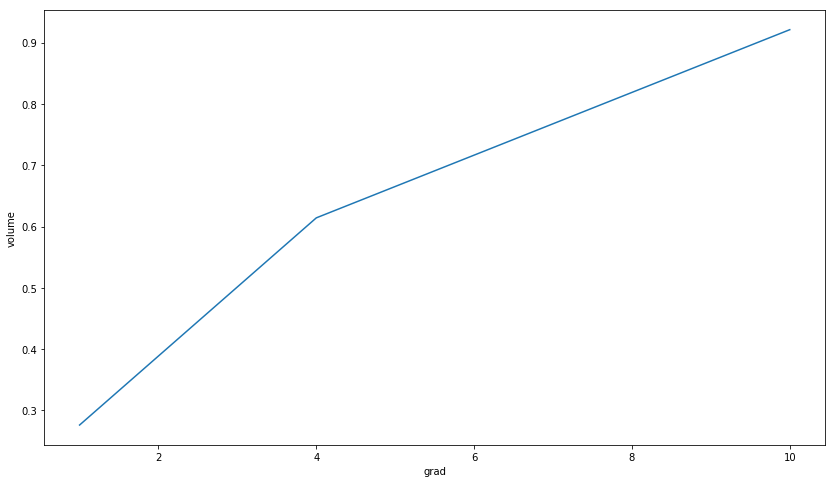

In [8]:
# Plot the volume depending on the gradient
plt.figure(figsize=[14,8])
plt.plot(table['grad'], table['volume'])
plt.xlabel('grad')
plt.ylabel('volume');

We will add some more values. Be patient, the calculation will take a little bit longer.

In [10]:
# We will calculate models with the MBGs: 1 to 19 with stepsize 2
grad = list(range(1,21,2))
# In the following lists the intermediate steps of the models willbe saved
mb_models = []
annual_mb = []
# here the "final" models will be saved
models = []
                               
for k, gradient in enumerate(grad):
    a = LinearMassBalance(3000, grad=gradient)
    mb_models.append(a)
    # Calculation of the annual mass balance along the glacier profile
    annual_mb.append(a.get_annual_mb(surface_h) * cfg.SEC_IN_YEAR)
    # The models require the initial glacier bed, a mass-balance model, and an initial time (the year y0)
    models.append(FlowlineModel(init_flowline, mb_model=a, y0=0.))
    # First, look at the state of the glacier models after 300 years
    models[k].run_until(300)
for model in models:
        model.run_until_equilibrium()

In [ ]:
# Plot it
#plt.figure(figsize=[14,8])
#plt.plot(distance_along_glacier, init_flowline.surface_h, label='Initial glacier')

#for k, model in enumerate(models):
    #model.run_until_equilibrium()
    # Get the modelled flowline (model.fls[-1]) and plot its new surface
    #plt.plot(distance_along_glacier, model.fls[-1].surface_h, label='Glacier after {} years, '.format(model.yr) + 'grad=' + str(grad[k]))
# Add the bedrock:
#hf.plot_xz_bed(distance_along_glacier, bed_h)

Have a look at the years when the glacier models reach their equilibrium. It is unlikely that all models up to a grad of 9 reach their equilibrium state after 305 years. Do you know what happend?

In [11]:
# create lists with different properties of the glacier models
volume = []
area = []
length = []
year = []

for model in models:
    year.append(model.yr)
    volume.append(model.volume_km3)
    length.append(model.length_m)
    area.append(model.area_km2)

dic = {'grad': grad, 'year': year, 'volume': volume, 'area': area, 'length': length}
table = pd.DataFrame.from_dict(dic)
table

,grad,year,volume,area,length
0,1,1260.0,0.412196,3.06,10200.0
1,3,590.0,0.573964,3.36,11200.0
2,5,415.0,0.651045,3.48,11600.0
3,7,325.0,0.722736,3.57,11900.0
4,9,305.0,0.784169,3.66,12200.0
5,11,305.0,0.834469,3.72,12400.0
6,13,305.0,0.879500,3.78,12600.0
7,15,305.0,0.921246,3.84,12800.0
8,17,305.0,0.957507,3.87,12900.0
9,19,305.0,0.990318,3.90,13000.0


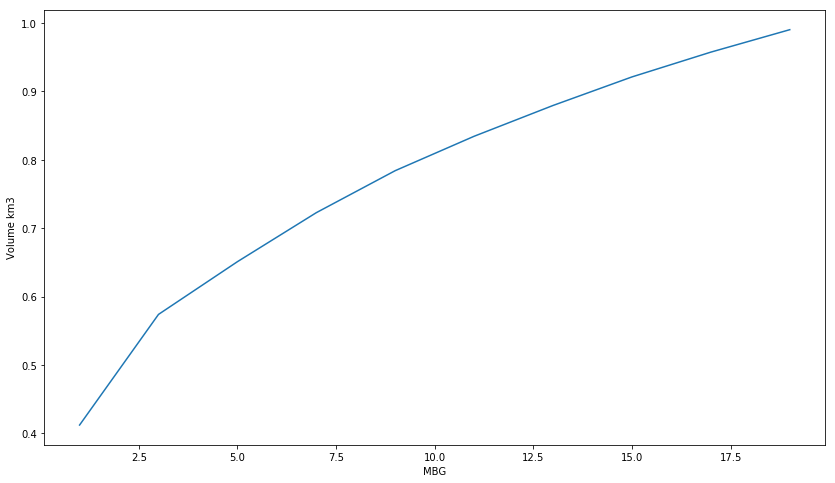

In [12]:
# Plot it
plt.figure(figsize=[14,8])

plt.plot(table['grad'], table['volume'])
plt.xlabel('MBG')
plt.ylabel('Volume km3');

## Response time
The glacier response time is the period of time a glacier needs to adjust its geometry to changes in mass balance caused by climate change and reach a new equilibrium state.

Let's simulate a climate change by changing the mass balance gradient a little bit. We take the three glacier models from the beginning:


In [23]:
grad = [0.3, 0.4, 4.0, 4.1, 15.0, 15.1]
years= [2000, 2000, 1, 1, 1, 1]
# In the following lists the intermediate steps of the models will be saved
mb_models = []
annual_mb = []
# here the "final" models will be saved
models = []
# Colors for the graphs

for k, gradient in enumerate(grad):
    # Calculation of the mass balance models for each gradient 
    a = LinearMassBalance(3000, grad=gradient)
    mb_models.append(a)
    # Calculation of the annual mass balance along the glacier profile
    annual_mb.append(a.get_annual_mb(surface_h) * cfg.SEC_IN_YEAR)
    # The models require the initial glacier bed, a mass-balance model, and an initial time (the year y0)
    models.append(FlowlineModel(init_flowline, mb_model=a, y0=0.))
    # First, look at the state of the glacier models after the chosen amount of years
    models[k].run_until(years[k])

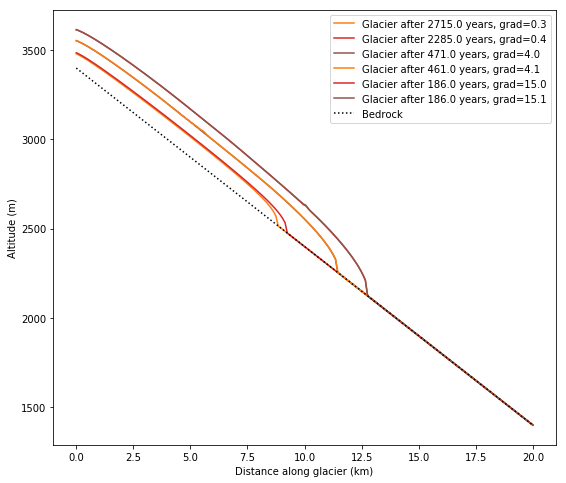

In [24]:
colors = ['C1', 'C3', 'C5', 'C1', 'C3', 'C5'] 

# run until equilibrium
plt.figure(figsize=(9,8))
for k, model in enumerate(models):
    # Run the different glacier models until they reach an equilibrium state
    model.run_until_equilibrium()
    # Get the modelled flowline (model.fls[-1]) and plot its new surface
    plt.plot(distance_along_glacier, model.fls[-1].surface_h, label='Glacier after {} years, '.format(model.yr) + 'grad=' + str(grad[k]), color=colors[k])
# Add the bedrock:
hf.plot_xz_bed(distance_along_glacier, bed_h)

Have a look at the times until the different models reach their equilibrium. The time difference for reaching the equilibrium between the glacier with gradient 0.3 and 0.4 is much higher than for 4.0 or 4.1. For the last model we cannot see a difference. From this founding we can conclude that glaciers with a small MBG need much more time to adjust to climate changes than glaciers with high MBGs (under the term that the changes are similiar).